 # Demo for Model2

# Getting Started

Our Demo consist of two steps, Step 1 consist of reading data, creating model, training and testing and then creating saving the model. Step 2 is to run our pretrained model and valuate results and observe prediction.
##### Step 1. Create your own model 
##### Step 2. Load our model and see results 

### Top 1 Top5 and Top 10 accuracies for 50 classes

Model 2 - This model is trained on 50 random classes. We have calculated the top1, top5 and top 10 accuracy for this model. We have also displayed few prediction using interactive classification for our model by loading th model created.

## Step 1. Create your own model 

In [101]:
SEED = 42
from random import seed as py_seed
py_seed(SEED)
from numpy.random import seed as np_seed
np_seed(SEED)
from tensorflow import random as tf_random
tf_random.set_seed(SEED)

### Importing libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import KFold, train_test_split
from keras import backend as K
import keras
import tensorflow as tf
import functools

Using TensorFlow backend.


### Reading Data for 50 random classes

In order to load in the data you will need to download the Food 101 data set that we have linked in our README.rd. and unzip and keep it same folder with this file.

In the code below we are randomly selecting 50 classes from our entire dataset

In [3]:
# Data comes from here. This should contain a bunch of folders of classes, each containing examples
#DATA_PATH = Path('food-101-original-source/images')
DATA_PATH = Path('food-101/images')

# Get class (folder) names
classes = sorted([entry.name for entry in DATA_PATH.iterdir() if entry.is_dir()])

SPLIT = 50
random.shuffle(classes) # shuffle the classes 
classes = classes[:SPLIT]
classes = sorted(classes)
# Load list of filenames and classes, and convert to numpy array to allow array slicing
# For k-fold validation
dataset = np.array([
    (f"{clazz}/{entry.name}", clazz)
    for clazz in classes
    for entry in (DATA_PATH / clazz).iterdir()
])

After reading the classes we are saving the classes again into a text file called classes_50.txt. 

### Class labels

To verifiy that everything has come in correctly we have printed out our set of class labels that will be used for labeling our data. Here we have listed all 50 food classes found in the Food 101 dataset.

In [4]:
# Randomly selected classes 
print(classes)

['baby_back_ribs', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'cannoli', 'ceviche', 'chicken_curry', 'chocolate_cake', 'churros', 'crab_cakes', 'deviled_eggs', 'dumplings', 'edamame', 'eggs_benedict', 'falafel', 'filet_mignon', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_rice', 'frozen_yogurt', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'gyoza', 'huevos_rancheros', 'hummus', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'miso_soup', 'nachos', 'omelette', 'paella', 'panna_cotta', 'peking_duck', 'pho', 'pork_chop', 'prime_rib', 'ramen', 'risotto', 'sashimi', 'seaweed_salad', 'spring_rolls', 'steak', 'takoyaki', 'tuna_tartare']


This step is not so important for Model-1 with all 101 classes, but it is very important for Model-2 and Model-3. Because the classes are randomly selected each time the model is created and we would like to save the selected classes for that model.
We are selecting random classes for both the models to avoid any biases.

"classes_50.txt" will be saved in the same folder where this file is stored

In [60]:
# saving classes used by this model
with open('classes_50.txt', 'w') as f:
    f.writelines("%s\n" % clss for clss in classes)

### Implementing Datagen to read data

Because we are working with a 5 GB dataset we need to load the images in as needed. All the images need to be the same size and be captured in the same area of the picture. For this we used the ImageDataGenerator method

In [5]:
# create data generators

# Rescale 0-255 to 0-1
RESCALE=1./255

# This type of data generator is used to train the model
train_datagen = ImageDataGenerator(
    rescale=RESCALE,
    # Factors used to control
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images

)

# This type of generator is used to test the model
test_datagen = ImageDataGenerator(
    rescale=RESCALE,
)




### Function for Top 10 accuracy

Since the WebApp we are creating will use the top 10 possible options for food selection we need to capture the top-10 accuracy for each predicition

Since users will be taking pictures from their phones we needed to compensate for a few things in the image such as lack of quality, noise in the image, other food objects in the image, food shape or color difference from what was trained on, or missing that food category in our training set.

In [6]:
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)

top10_acc.__name__ = 'top10_acc'

### Our Model Architecture

Our model is extended from using a pre-trained model call NASNetMobile. We have included custom metrics according to our requirement of top1, top5 and top10 accuracy 

In [7]:
def create_model(input_shape, num_classes):
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = RMSprop()

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy', 'top_k_categorical_accuracy',top10_acc]  # top1, top5 and top10 accuracies
    )
    
    return model

### Creating Training and testing Data

The below code is the heart of our project. In this piece of code we are diving our data into test and train.
Our test data is 10 percent of our entire dataset and rest 90 percent is our training data. We are further dividing our train data into 10 percent validation and 90 percent train.

After creating training and test data. We are calling our create model function to train it and validate it. printing its training progress details

In [8]:
# Image data generator settings
TARGET_SIZE = (224,224)
COLOR_MODE = "rgb"
BATCH_SIZE = 64
CLASS_MODE = "categorical"


# Training settings
NUM_FOLDS = 5
VALIDATION_SPLIT = 0.1
NUM_EPOCHS = 5

# Create train and test dataset
d_train, d_test = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# Extract train dataset
#d_train = dataset[train_index]
# Split train dataset to form train and validation dataset
d_train, d_val = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# These are used to convert the filename,class pairs to dataframes
FILENAME_COL = "filename"
CLASS_COL = "class"
COLUMNS = [FILENAME_COL, CLASS_COL]
# Convert to dataframes
d_train = pd.DataFrame(d_train, columns = COLUMNS)
d_val = pd.DataFrame(d_val, columns = COLUMNS)

# Create training data generators
# Training image data generator
train_it = train_datagen.flow_from_dataframe(
    d_train,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = True,
    seed = SEED
)
# Validation image data generator
val_it = test_datagen.flow_from_dataframe(
    d_val,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)

# Perform training
# Build the model
input_shape = (*TARGET_SIZE,3)
num_classes = len(classes)
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True
)



Found 45000 validated image filenames belonging to 50 classes.
Found 5000 validated image filenames belonging to 50 classes.
Epoch 1/5
704/704 [==============================] - 1432s 2s/step - loss: 2.9194 - accuracy: 0.2556 - top_k_categorical_accuracy: 0.5280 - top10_acc: 0.6758 - val_loss: 3.1545 - val_accuracy: 0.3478 - val_top_k_categorical_accuracy: 0.6638 - val_top10_acc: 0.7986
Epoch 2/5
704/704 [==============================] - 1395s 2s/step - loss: 2.4194 - accuracy: 0.3669 - top_k_categorical_accuracy: 0.6683 - top10_acc: 0.8018 - val_loss: 3.2525 - val_accuracy: 0.3622 - val_top_k_categorical_accuracy: 0.6764 - val_top10_acc: 0.8138
Epoch 3/5
704/704 [==============================] - 1428s 2s/step - loss: 2.3269 - accuracy: 0.3883 - top_k_categorical_accuracy: 0.6901 - top10_acc: 0.8196 - val_loss: 2.8889 - val_accuracy: 0.3756 - val_top_k_categorical_accuracy: 0.6854 - val_top10_acc: 0.8248
Epoch 4/5
704/704 [==============================] - 1409s 2s/step - loss: 2.305

### Evaluating our model on the test data

We are evaluating our final Top1, Top2, Top3 accuracy on the test data 

In [10]:
d_test = pd.DataFrame(d_test, columns = COLUMNS)

# Extract test dataset and convert to dataframe
#d_test = pd.DataFrame(dataset[test_index], columns = COLUMNS)
# Create test image data generator
test_it = test_datagen.flow_from_dataframe(
    d_test,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)


Found 5000 validated image filenames belonging to 50 classes.


In [11]:
# Test
loss, accuracy, top5acc, top10acc = model.evaluate(test_it)

print(f"Test Accuracy Top-1: {accuracy * 100}%, Top-5: {top5acc * 100}%, Top-10: {top10acc * 100}%")

79/79 [==============================] - 114s 1s/step
Test Accuracy Top-1: 38.10000121593475%, Top-5: 70.53999900817871%, Top-10: 84.10000205039978%


### Plotting accuracies

We can then plot the accuracy and loss of each of our outputs as well as the total loss of the neural net. After plotting the data we then automatically save the model based on its statistics.

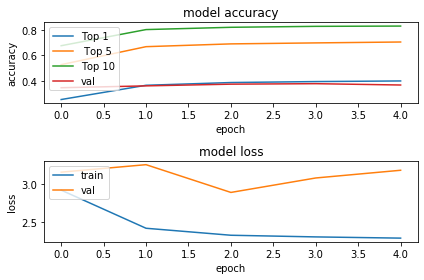

In [12]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['top10_acc'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Top 1', ' Top 5','Top 10' , 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()

### Here we are Saving our Model 

In [13]:
model.save("model-50.h5")

# Step 2. Load our model and see results

## Interactive Classification

In Interactive classification we displaying the Top1, Top 5 and Top 10 prediction made by model 2 (50 random classes) 

Note: selecting image from only 50 randomly selected classes

In [72]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np 
from keras.models import Sequential 
#from keras.layer import 
import keras
import functools

Since our model has custom metrics we had to specify the custom function we are using before loading our model

In [73]:
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)

top10_acc.__name__ = 'top10_acc'

## Loading Model for prediction

Then we use load_model function to load our model created in Step 1.

Keras load_model has an attribute 'custom_objects' which is by default set to 'None', But if you have a custom metrics for either loss or accuracy you must mention it as displayed below. 

In [87]:
# loading model 
model = tf.keras.models.load_model("model-50.h5", custom_objects={'top10_acc':top10_acc})

## Loading Label

We are loading labels from the previously created 'classes_50.txt' file.

Again this step is important because we have different classes for Model1, Model2, and Model3. And for Model2 and Model3 these classes are randomly created every time a new model is created in Step 1.

In [ ]:
# getting the classes
classes=[]
with open("classes_50.txt") as categories:
    for cl in categories:
        classes.append(cl.strip())

In [88]:
from PIL import Image
# change the file name if you want to test it with different picture
image_path = []
image_path.append("images_to_predict/6.jpg") 
image_path.append("images_to_predict/1.jpg")
image_path.append("images_to_predict/46.jpg") 

Resizing the image and converting to array. The prediction for all the image are storeed in result list.

In [89]:
imgPred = []
result = []
for im in range(len(image_path)):
    image = []
    img_resize = (224,224)
    img = Image.open(image_path[im])
    img = img.resize(img_resize)
    img = np.asarray(img)
    image.append(img)
    data_train = np.array(image, dtype=np.float32)/255
    prediction = model.predict([data_train])
    result.append(classes[np.argmax(prediction)])
    imgPred.append( plt.imread(image_path[im]) )

Take care of the index 0 (zero) is for first image imgPred[0] and result[0]. Rest everything is same

'edamame'

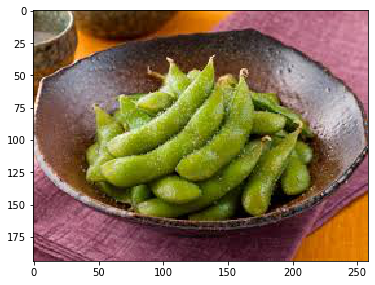

In [90]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[0])
result[0]

Take care of the index 1 (one) is for second image imgPred[1] and result[1]. Rest everything is same

'spring_rolls'

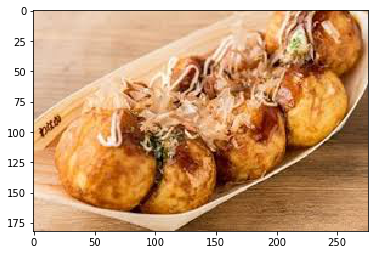

In [91]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[1])
result[1]  # should be takoyaki

Take care of the index 2 (two ) is for third image imgPred[2] and result[2]. Rest everything is same

'eggs_benedict'

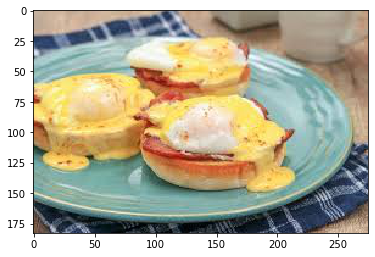

In [92]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[2])
result[2] ## Its Egg benedict

## Top 5 and Top 10 Prediction

In [93]:
imgPred = []
result = []
top10 = [] 
for im in range(len(image_path)):
    image = []
    img_resize = (224,224)
    img = Image.open(image_path[im])
    img = img.resize(img_resize)
    img = np.asarray(img)
    image.append(img)
    data_train = np.array(image, dtype=np.float32)/255
    prediction = model.predict([data_train])
    result.append(classes[np.argmax(prediction)])
    sorted_prediction = []
    for i in range(len(classes)):
        temp=[]
        temp.append(classes[i])
        temp.append(prediction[0][i])
        sorted_prediction.append(temp)
    sor = sorted(sorted_prediction,key=lambda ls:ls[1], reverse=True)
    res = []
    for j in range(0, 10):
        res.append(sor[j][0]) 
    top10.append(res)

### Display top 5 and top 10 for all the images

In below code top10[0][i] and image_path[0] zero here represents first image. You can replace 0 with 1,2,3 etc. Rest everything remains the same

top 5 and top 10:
edamame
gnocchi
macaroni_and_cheese
ceviche
ramen
chicken_curry
bibimbap
risotto
huevos_rancheros
eggs_benedict


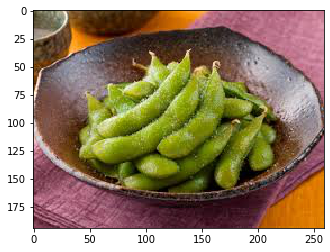

In [94]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[0][i])
img = plt.imread(image_path[0])
plt.imshow(img) # should be edamame

top 5 and top 10:
spring_rolls
breakfast_burrito
omelette
lobster_roll_sandwich
takoyaki
bruschetta
grilled_salmon
gyoza
chicken_curry
huevos_rancheros


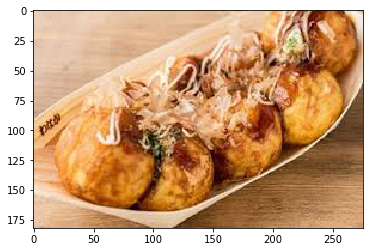

In [95]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[1][i])
img = plt.imread(image_path[1])
plt.imshow(img) # should be takoyaki

top 5 and top 10:
eggs_benedict
deviled_eggs
french_toast
bruschetta
grilled_salmon
huevos_rancheros
bread_pudding
pork_chop
crab_cakes
ceviche


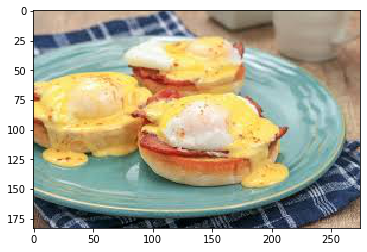

In [96]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[2][i])
img = plt.imread(image_path[2])
plt.imshow(img) ## Should be Egg benedict

## THE END

NOTE:  Model2-Demo.ipynb and Model3-Demo.ipynb are same as this file we have just reduced the number of classes from 50 and 25. And These Classes are randomly selected and they are present in the same folder. Just follow the same instructions